# Using Fruitbowl Part 2: Visualisation and Analysis
### In Part 1 we scraped the internet for documents and created a corpus and trained representation vector models

Now lets use these vectors in analysis techniques

Lets load in a pre-trained model (This is a memory intensive operation and may take some time)

In [ ]:
import gensim.models.doc2vec as doc2vec
d2v_model = doc2vec.Doc2Vec.load('fruitbowl/strawberry/models/FULLDOC2VEC')

# Now, lets create a corpus and get a sample to analyse

We are using a very large corpus of 450 000 documents that has been used to train the model we just loaded

(This is also could take some time, but is a streaming operation so has more modest memory usage)

In [3]:
from fruitbowl.orange import corpus,docIterators 
from fruitbowl.strawberry import model_training,vect_generators

doc_iterator = docIterators.JsonDiskIter('fruitbowl/orange/Example_Corpus/LARGE_MINIMISED.json')
corp=corpus.Corpus('Large_Example_Corpus',doc_iterator)
d2v_gen = vect_generators.Doc2VecGenerator(d2v_model)

samples=corp.get_sample(5000)

Building Dictionary
[######### ] 99% 464000

Sampling 5000 random documents
[######### ] 99% 464000



# With the sample and model loaded into memory, we can perform several analyses
Lets generate the vectors for this sample and visualise using euclidean dimensional reduction:

* PCA
* TSNE

These operations can also take some time due to the relatively high number of dimensions involved



In [10]:
from fruitbowl.apple import dim_reduction
import numpy as np
vecs = []
for sample in samples:
    vecs.append(d2v_gen.get_vector(sample['doi']))
np_vecs = np.array(vecs).T
#reduced_vecs_pca = dim_reduction.reduce_dimensions(vecs,TSNE=False) #pca
#reduced_vecs_tsne = dim_reduction.reduce_dimensions(vecs) #TSNE

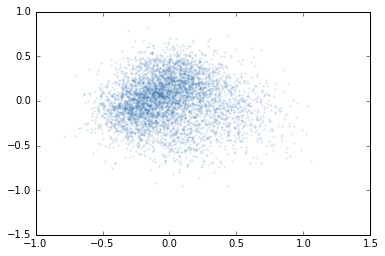

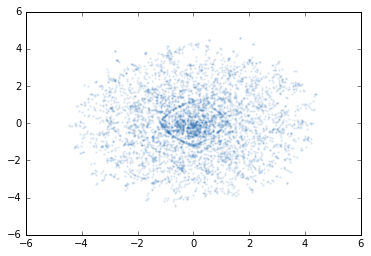

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
blue='#246bb0'
plt.scatter(reduced_vecs_pca[:,0],reduced_vecs_pca[:,1],s=2,alpha=0.1,color=blue)
plt.show()
plt.scatter(reduced_vecs_tsne[:,0],reduced_vecs_tsne[:,1],s=2,alpha=0.1,color=blue)
plt.show()

# Fruitbowl is most effective when analysing cosine similarities
#### Cosine similarities can be interpreted as inverse distances (1-cosine &sim; dist)
The `analysis_tools.py` module facilitates much of this work 
* First, compute the cosine matrix 
* We can get the closest similarities using the method `get_doi_sims`. In this case, we're getting the most similar articles to the first document in the sample
* we can also get average similarities between a sample


In [11]:
from fruitbowl.apple import analysis_tools

matrix = analysis_tools.cosine_mat(np_vecs,np_vecs)

'''doi_list = [s['doi'] for s in samples]
sims = analysis_tools.get_doi_sims(np_vecs[:,23],_,np_vecs,doi_list)
print('Similarities:')
for k,v in sims.items():
    print(str(k)+' : '+str(v))
most_sim1 = [s for s in samples if s['doi']==sims[1]['doi']][0]
most_sim2= [s for s in samples if s['doi']==sims[2]['doi']][0]
print('\nArticle to compare to: \n'+'. '.join([' '.join(s) for s in most_sim1['doc']]))
print('\nmost similar article found: \n' + '. '.join([' '.join(s) for s in most_sim2['doc']]))

ave_sim = analysis_tools.get_ave_sim(np_vecs)
print('\naverage similarity of pairs: '+str(ave_sim))'''


"doi_list = [s['doi'] for s in samples]\nsims = analysis_tools.get_doi_sims(np_vecs[:,23],_,np_vecs,doi_list)\nprint('Similarities:')\nfor k,v in sims.items():\n    print(str(k)+' : '+str(v))\nmost_sim1 = [s for s in samples if s['doi']==sims[1]['doi']][0]\nmost_sim2= [s for s in samples if s['doi']==sims[2]['doi']][0]\nprint('\nArticle to compare to: \n'+'. '.join([' '.join(s) for s in most_sim1['doc']]))\nprint('\nmost similar article found: \n' + '. '.join([' '.join(s) for s in most_sim2['doc']]))\n\nave_sim = analysis_tools.get_ave_sim(np_vecs)\nprint('\naverage similarity of pairs: '+str(ave_sim))"

# The matrix can be converted into a graph that can be loaded into graph viewing programs like gephi:
#### The module `gephi_tools.py` faciliates this.
* Fist argument is node labels
* Second arguemnt is the matrix to convert into the graph
* 'threshold' is a cosine similarity value below which where edges are cut so that the graph is not over-connected

In [121]:
from fruitbowl.apple import gephi_tools

gephi_tools.gexf_gephi_exporter(doi_list,matrix,filename='example_graph.gexf',threshold=0.3)


graph exported :example_graph.gexf


# The sample can be divided into communities using a recursive community finding algorithm
#### This can be performed using the `community_generation.py` package
* The algorithm requires as a java development kit, maven and an internet connection (first time only).
* The procedure requires a a cosine matrix and s dictionary with primary keys for each document, and the values dictionaries containing the key `vector` and the value containing the representation vector

In [68]:
from fruitbowl.pomegranate import community_generation
from collections import Counter

sample_with_vecs = {s['doi']:{'vector':d2v_gen.get_vector(s['doi'])} for s in samples}
communities, community_tree_paths = community_generation.generate_communities(matrix,samp_key)

c = Counter([len(x) for x in communities.values()])
print('\nNo. of communities found: ' + str(len(communities)) )
print('Populations of Communities found: ')
for k,v in c.most_common(): 
    print('    Communities with '+ str(k)+ ' documents: '+str(v) )

Communities Generated
Reducing community 274
Communities Generated
13 Communities remaining to subdivide
Reducing community 267
Communities Generated
12 Communities remaining to subdivide
Reducing community 262
Communities Generated
11 Communities remaining to subdivide
Reducing community 260
Communities Generated
10 Communities remaining to subdivide
Reducing community 257
Communities Generated
9 Communities remaining to subdivide
Reducing community 250
Communities Generated
8 Communities remaining to subdivide
Reducing community 241
Communities Generated
7 Communities remaining to subdivide
Reducing community 234
Communities Generated
6 Communities remaining to subdivide
Reducing community 232
Communities Generated
5 Communities remaining to subdivide
Reducing community 231
Communities Generated
4 Communities remaining to subdivide
Reducing community 220
Communities Generated
3 Communities remaining to subdivide
Reducing community 213
Communities Generated
2 Communities remaining to 